In [1]:
from tensorflow import keras
import dlib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
model = keras.models.load_model('model.h5')
model.summary()

detector = dlib.get_frontal_face_detector()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 256)      

In [3]:
img_Angry = cv2.imread("Image_fer/00_Angry_Second.png")
img_Disgust = cv2.imread("Image_fer/01_Disgust_Second.png")
img_Fear = cv2.imread("Image_fer/02_Fear_Second.png")
img_Happy = cv2.imread("Image_fer/03_Happy_Second.png")
img_Sad = cv2.imread("Image_fer/04_Sad_Second.png")
img_Surprise = cv2.imread("Image_fer/05_Surprise_Second.png")
img_Neutral = cv2.imread("Image_fer/06_Neutral_Second.png")

In [4]:
expression_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
colors = [(0,0,255),(0,0,0),(135,138,128),(18,153,255),(255,0,0),(240,32,160),(0,255,0)]

# 0:紅色, 1:黑色, 2:灰色, 3:橘色, 4:藍色, 5:紫色, 6:綠色
# 0:生氣, 1:厭惡, 2:恐懼, 3:開心, 4:難過, 5:驚訝, 6:中立

In [5]:
# 將Dlib轉成list型式:(x, y, w, h)

def detect_faces(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face = detector(frame)
    faces = []
    
    for i in range(len(face)):
        x = face[i].left()
        y = face[i].top()
        w = face[i].right()-face[i].left()
        h = face[i].bottom()-face[i].top()
        if x<0:
            x = 0
        if y<0:
            y = 0
        faces.append((x, y, w, h))
        
    return gray, faces

In [6]:
def face_check(frame):
    gray, faces = detect_faces(frame)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)[0]
        pred_list = prediction.tolist()
        pred_max = max(pred_list)
        index = pred_list.index(pred_max)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 4)
        cv2.putText(frame,"{}: {}".format(expression_dict[index],round(pred_max,3)),
                    (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,colors[index],2)
        frame = face_post(frame, (x, y), w, expression_dict[index])
        
    return frame

In [7]:
def face_post(frame, top_left, width, prediction):
    
    if prediction =="Angry":
        img = img_Angry
    if prediction =="Disgust":
        img = img_Disgust
    if prediction =="Fear":
        img = img_Fear
    if prediction =="Happy":
        img = img_Happy
    if prediction =="Sad":
        img = img_Sad
    if prediction =="Surprise":
        img = img_Surprise
    if prediction =="Neutral":
        img = img_Neutral
    
    img_wh = int(width/2)
    img = cv2.resize(img, (img_wh,img_wh))
        
    img_top_left = (int(top_left[0]-img_wh),int(top_left[1]))
    img_bottom_right = (int(top_left[0]),int(top_left[1]+img_wh))
    
    if img_top_left[0]>0 and img_top_left[1]>0:

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(img_gray, 25, 255, cv2.THRESH_BINARY_INV)
    
        area = frame[img_top_left[1]: img_top_left[1]+img_wh, img_top_left[0]: img_top_left[0]+img_wh]
        area_no = cv2.bitwise_and(area,area,mask=mask)
        final = cv2.add(area_no, img)
        frame[img_top_left[1]: img_top_left[1]+img_wh, img_top_left[0]: img_top_left[0]+img_wh] = final

    return frame

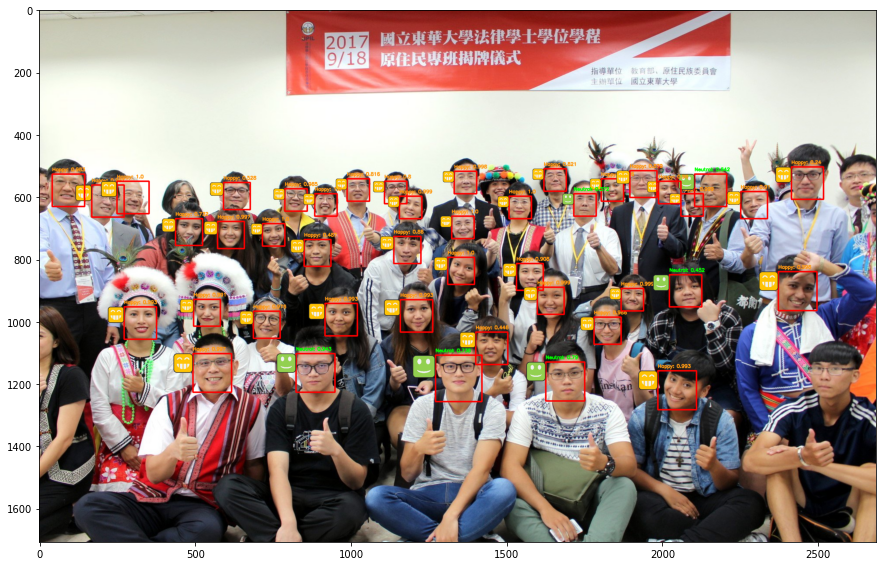

In [8]:
img = cv2.imread("Face_test.jpg")
img = cv2.resize(img, None, fx=1.4, fy=1.4)
img = face_check(img)

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, img = VIDEO_IN.read()
    img = cv2.resize(img, None, fx=0.5, fy=0.5)
    img = face_check(img)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()